In [1]:
from google.colab import drive
drive.mount('/drive')
%cd /drive

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive


In [2]:
%cd MyDrive/
!ls

/drive/MyDrive
'Colab Notebooks'		  Fashion-MNIST         VGG16
'Eğitim - enesusta.com.tr'	  save_models
'Facial Expression Recognition'  'Slience Of Night V'


In [3]:
%cd Facial Expression Recognition

/drive/MyDrive/Facial Expression Recognition


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [5]:
root = '/drive/MyDrive/Facial Expression Recognition'
data = pd.read_csv(root+'/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
print('Shape:',data.shape)

Shape: (35887, 3)


In [7]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [8]:
np.unique(data['Usage'].values.ravel())
print('Egitim Setindeki Örnek Sayısı: %d'%len(data[data.Usage=="Training"]))

Egitim Setindeki Örnek Sayısı: 28709


In [9]:
train_data = data[data.Usage == "Training"]
train_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
train_pixels = train_data.pixels.str.split(" ").tolist()
train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)
print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
def show(img):
  show_image = img.reshape(48, 48)
  plt.axis('off')
  plt.imshow(show_image, cmap='gray')


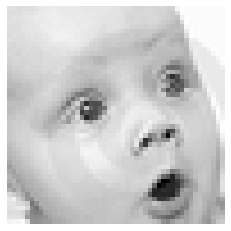

In [12]:
show(train_images[22066])

In [13]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı Yüz İfadelerinin Sayısı: %d'%train_labels_count)

Farklı Yüz İfadelerinin Sayısı: 7


In [14]:
def dense_to_one_hot(labels_dense, num_classes):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [15]:
y_train = dense_to_one_hot(train_labels_flat,train_labels_count)
y_train = y_train.astype(np.uint8)
print(y_train.shape)

(28709, 7)


In [16]:
np.unique(data["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [17]:
test_data = data[data.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

(3589, 2304)


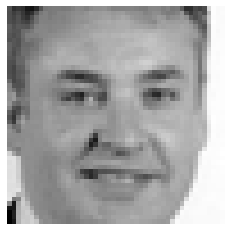

In [18]:
show(test_images[200])

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


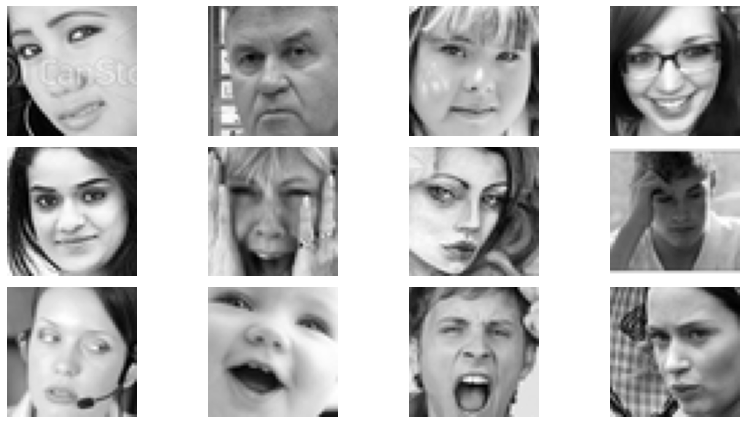

In [20]:
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In [21]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

In [22]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)
print('Train:',x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [23]:
print('Train:',y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [ ]:
# en başarılı agırlıları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 180
batchSize = 100

#modeli çalıştır
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True, # karışık bir şekilde eğit
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer],
                 verbose=2)

# model json olarak kaydetme

model_json = model.to_json()
with open(root+'data/face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/180
288/288 - 8s - loss: 0.9913 - accuracy: 0.6276 - val_loss: 1.0328 - val_accuracy: 0.6060

Epoch 00001: val_loss improved from inf to 1.03280, saving model to /drive/MyDrive/Facial Expression Recognitiondata/face_model.h5
Epoch 2/180
288/288 - 8s - loss: 0.9886 - accuracy: 0.6262 - val_loss: 1.0671 - val_accuracy: 0.5918

Epoch 00002: val_loss did not improve from 1.03280
Epoch 3/180
288/288 - 8s - loss: 0.9864 - accuracy: 0.6276 - val_loss: 1.0538 - val_accuracy: 0.6057

Epoch 00003: val_loss did not improve from 1.03280
Epoch 4/180
288/288 - 8s - loss: 0.9814 - accuracy: 0.6299 - val_loss: 1.0240 - val_accuracy: 0.6108

Epoch 00004: val_loss improved from 1.03280 to 1.02401, saving model to /drive/MyDrive/Facial Expression Recognitiondata/face_model.h5
Epoch 5/180
288/288 - 8s - loss: 0.9819 - accuracy: 0.6299 - val_loss: 1.0390 - val_accuracy: 0.6113

Epoch 00005: val_loss did not improve from 1.02401
Epoch 6/180
288/288 - 8s - loss: 0.9800 - accuracy: 0.6279 - val_loss: 

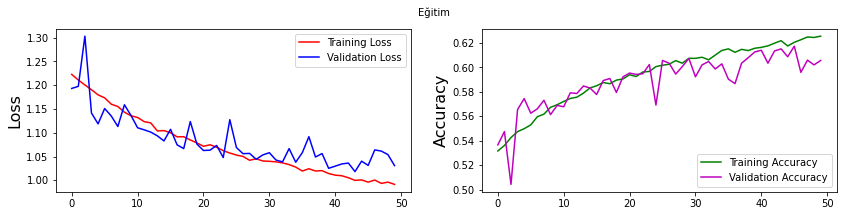

In [32]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [33]:
test = data[['emotion', 'pixels']][data['Usage'] == 'PrivateTest']
test['pixels'] = test['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [34]:
x_test_private = np.vstack(test['pixels'].values)
y_test_private = np.array(test['emotion'])

In [36]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [37]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("Private Test Üzerindeki Doğruluk Durumu:", score)

Private Test Üzerindeki Doğruluk Durumu: [1.0051289796829224, 0.61521315574646]


In [39]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

In [40]:
# en iyi ağırlıkları yükle
model_best = load_model(root + 'data/face_model.h5')

In [104]:
  
def predict_file(file):

    #test_image=x_test_private[60] #eğer veri kümesinden bir görsel denemek isterseniz burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!
    image_path = root+'/'+ file

    test_image_original = image.load_img(image_path) # orjinal renkli görüntü

    test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
    test_data = image.img_to_array(test_image)

    test_data = np.expand_dims(test_data, axis=0)
    test_data = np.vstack([test_data])

    results = model_best.predict(test_data, batch_size=1)
    print(results)

    #sınıflarımız 7 adet duygu durumumuz
    class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

    ind = 0.1+0.6*np.arange(len(class_names))
    width = 0.4  #bar genişliği

    color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

    # test resmimizi çizdirelim

    plt.imshow(test_image_original)
    plt.title('Giriş Resmi', fontsize=16)
    plt.axis('off')
    plt.show()

    #sonuçlarımızı renklendirelim

    for i in range(len(class_names)):
      plt.bar(ind[i], results[0][i], width, color=color_list[i])

    plt.title("Sınıflandırma Sonuçları", fontsize=20)
    plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
    plt.ylabel("Sınıflandırma Skoru",fontsize=16)
    plt.xticks(ind, class_names, rotation=45, fontsize=14)
    plt.show()


    print("\nSınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

    # en yüksek skorlu duyguya karşılık emoji çizdirelim

Test

In [106]:
!ls

acun.png  elon2.png  erdogan.png  indir.png   korkmuş.png  şaşırmış.png
alex.png  elon.png   fer2013.csv  kızgın.png  mutlu.png    üzülmüs.png


[[0.11701401 0.0026643  0.08116703 0.227897   0.38184848 0.00673893
  0.18267022]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


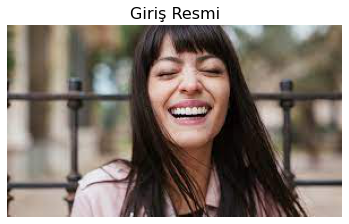

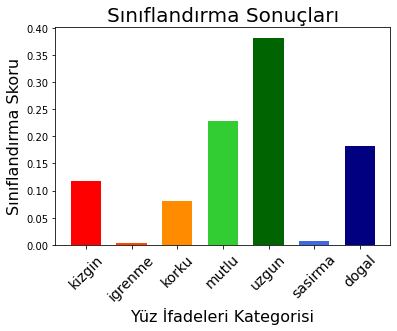


Sınıflandırma sonucu en yüksek oranla: uzgun


In [108]:
predict_file('mutlu.png')

[[0.15228114 0.00156228 0.11017621 0.03049266 0.3323648  0.02527303
  0.3478499 ]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


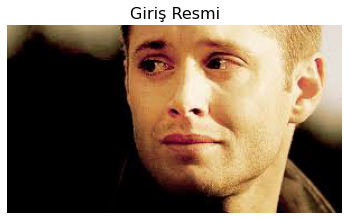

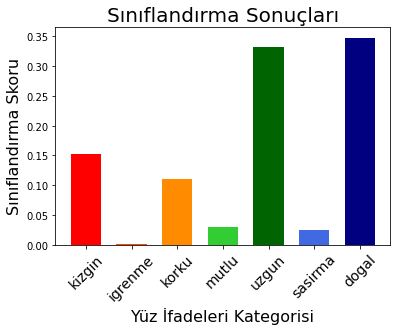


Sınıflandırma sonucu en yüksek oranla: dogal


In [111]:
predict_file('üzülmüs.png')

[[0.21423984 0.00204262 0.0497595  0.24864312 0.12144106 0.01770385
  0.34617   ]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


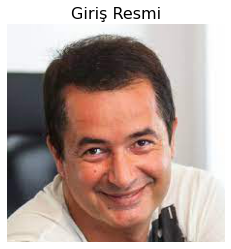

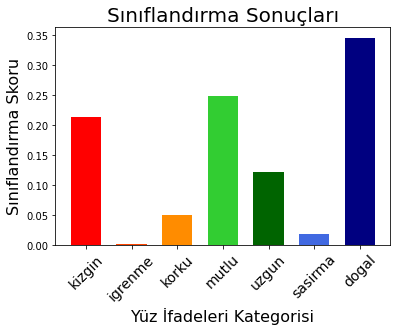


Sınıflandırma sonucu en yüksek oranla: dogal


In [112]:
predict_file('acun.png')

[[4.8868328e-01 3.2327938e-04 1.0237186e-01 6.3904934e-02 3.1178558e-01
  1.3642475e-02 1.9288696e-02]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


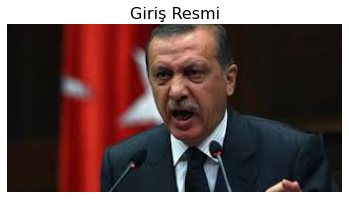

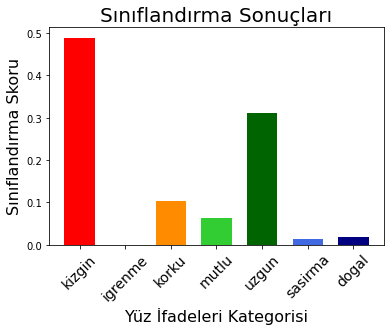


Sınıflandırma sonucu en yüksek oranla: kizgin


In [113]:
predict_file('erdogan.png')

[[0.28566703 0.00608427 0.23600382 0.09035232 0.29777697 0.0257111
  0.05840449]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


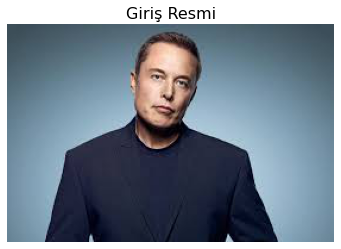

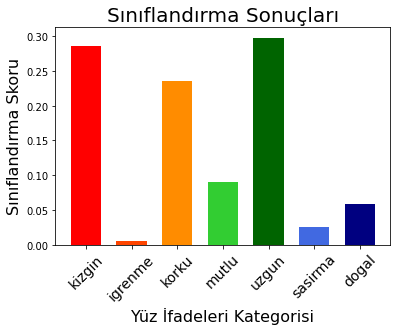


Sınıflandırma sonucu en yüksek oranla: uzgun


In [114]:
predict_file('elon.png')

[[0.43419844 0.00207472 0.1881175  0.10619815 0.20713708 0.00760116
  0.05467287]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


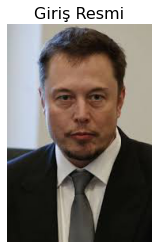

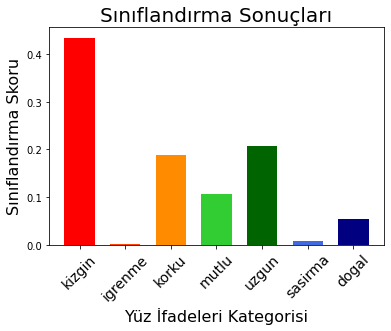


Sınıflandırma sonucu en yüksek oranla: kizgin


In [115]:
predict_file('elon2.png')

[[1.0433134e-03 8.7967113e-11 1.2594264e-05 9.9815768e-01 1.1720151e-05
  1.8751971e-06 7.7282841e-04]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


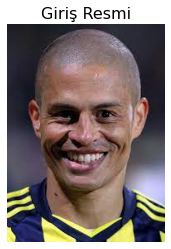

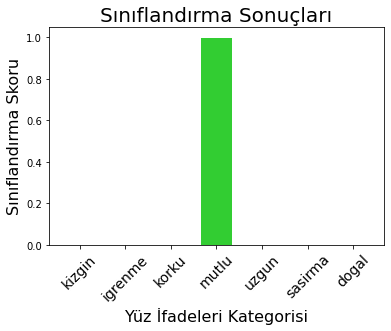


Sınıflandırma sonucu en yüksek oranla: mutlu


In [116]:
predict_file('alex.png')

[[0.30410993 0.0154265  0.23530589 0.01298122 0.34781092 0.03294034
  0.05142522]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


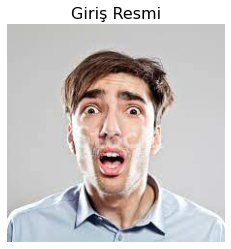

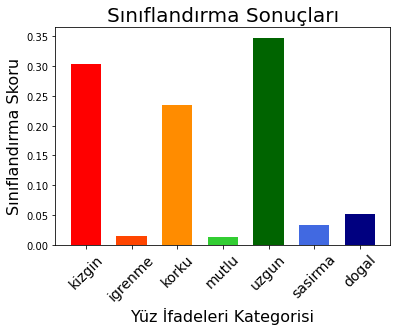


Sınıflandırma sonucu en yüksek oranla: uzgun


In [117]:
predict_file('korkmuş.png')

[[0.35905093 0.00288286 0.1726856  0.12625585 0.28907084 0.02137605
  0.02867787]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


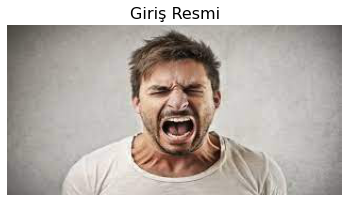

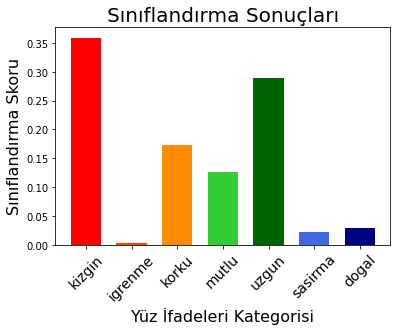


Sınıflandırma sonucu en yüksek oranla: kizgin


In [118]:
predict_file('kızgın.png')

[[0.10766654 0.0042607  0.24218027 0.04324898 0.33389914 0.16175157
  0.10699285]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


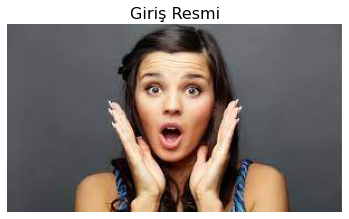

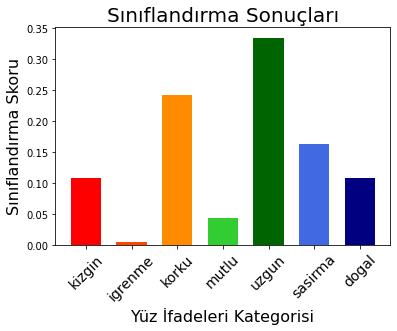


Sınıflandırma sonucu en yüksek oranla: uzgun


In [119]:
predict_file('şaşırmış.png')